In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [2]:
pd.options.display.max_columns = 50

In [3]:
summary = pd.read_csv('data/summary.csv')
day1 = pd.read_csv('data/day 1.csv')

In [4]:
summary.describe()

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,patient,temperature
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,2209.500000,7266.919005,8046.609729,7926.587557,8721.045475,8092.128281,26.843665,628.414706,2210.500000,36.872330
std,1276.088424,4146.204964,4449.402028,4448.635840,4443.100402,4449.621981,14.278000,466.094118,1276.088424,0.452982
min,0.000000,0.000000,113.000000,18.000000,574.000000,137.000000,1.000000,81.000000,1.000000,35.900000
25%,1104.750000,3774.500000,4297.750000,4188.500000,4952.250000,4343.250000,15.000000,337.000000,1105.750000,36.700000
50%,2209.500000,7229.500000,7992.500000,7871.500000,8721.000000,8072.500000,27.000000,490.000000,2210.500000,36.800000
75%,3314.250000,10914.250000,11816.750000,11692.000000,12448.750000,11867.000000,39.000000,774.250000,3315.250000,36.925000
max,4419.000000,14399.000000,18324.000000,18164.000000,19202.000000,18350.000000,50.000000,4833.000000,4420.000000,42.600000


In [5]:
day1.head(20)

,Unnamed: 0,assessment,day,event,patient,time
0,0,NaN,1,arrived,1,280
1,1,NaN,1,arrived,2,288
2,2,NaN,1,assessment initiated,1,308
3,3,NaN,1,arrived,3,430
4,4,urgent|36.599999999999994|no pain,1,assessment concluded,1,741
5,5,NaN,1,assessment initiated,2,764
6,6,NaN,1,consultation_initiated,1,773
7,7,normal|36.699999999999996|severe pain,1,assessment concluded,2,851
8,8,NaN,1,assessment initiated,3,878
9,9,NaN,1,consultation_initiated,2,905


In [6]:
summary.corr()['duration']

Unnamed: 0                -0.043085
arrival_time              -0.034497
assessment_end_time       -0.066131
assessment_start_time     -0.065776
consultation_end_time      0.038430
consultation_start_time   -0.066377
day                       -0.044200
duration                   1.000000
patient                   -0.044809
temperature                0.298949
Name: duration, dtype: float64

In [7]:
# sns.pairplot(summary);

In [8]:
summary.loc[summary['temperature'] <= 36.20, 'pain'].value_counts(normalize=True)

severe pain      0.950495
moderate pain    0.039604
no pain          0.009901
Name: pain, dtype: float64

In [9]:
summary.loc[summary['temperature'] <= 36.20, 'priority'].value_counts(normalize=True)

urgent    1.0
Name: priority, dtype: float64

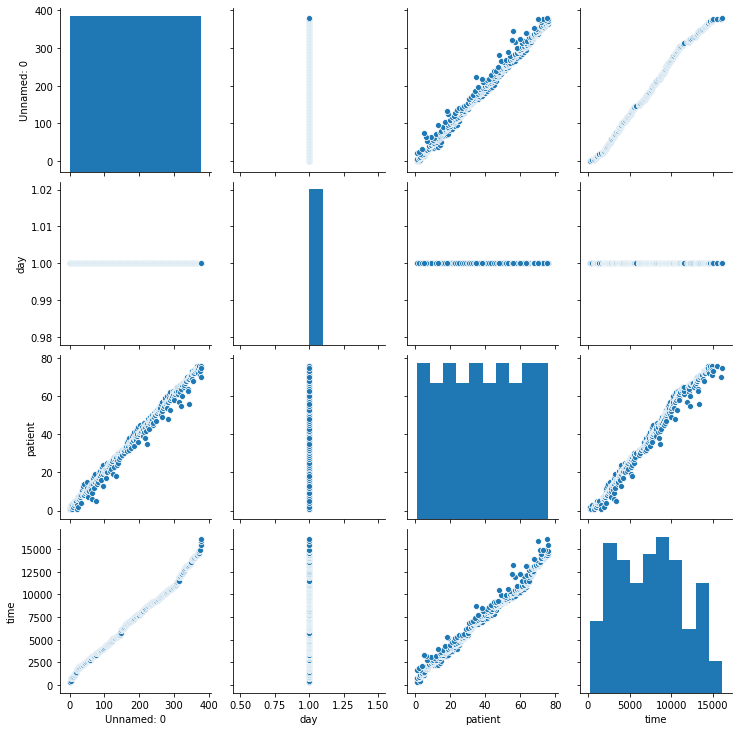

In [10]:
sns.pairplot(day1);

In [11]:
print(summary.shape)
print(len(summary['Unnamed: 0'].unique()))
print(len(summary['patient'].unique()))

(4420, 12)
4420
4420


In [12]:
summary.head(20)

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,1830,22,113,53,593,137,24,456,no pain,1831,normal,36.7
1,4220,22,113,49,749,193,49,556,no pain,4220,normal,36.8
2,822,8,131,39,1106,169,12,937,moderate pain,820,urgent,37.3
3,386,20,138,55,574,164,6,410,no pain,387,normal,36.7
4,4321,52,161,89,999,208,50,790,moderate pain,4322,urgent,37.1
5,1423,71,176,106,2730,206,19,2524,severe pain,1413,urgent,38.9
6,3926,76,180,100,1058,214,46,843,severe pain,3925,normal,37.4
7,1050,38,196,65,811,231,15,580,moderate pain,1051,normal,37.0
8,3517,17,198,54,1284,248,42,1035,severe pain,3518,normal,37.0
9,3428,0,203,18,966,232,41,734,moderate pain,3429,urgent,36.8


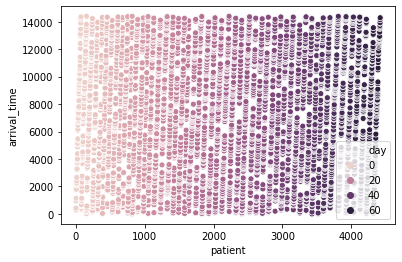

In [13]:
sns.scatterplot('patient', 'arrival_time', data=summary, hue='day');

In [14]:
summary.loc[summary['day'] == 50, 'arrival_time'].corr(summary.loc[summary['day'] == 50, 'patient'])

0.9953782079689507

In [15]:
df = summary.sort_values(['day', 'arrival_time'])

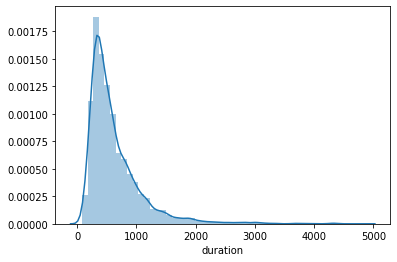

In [16]:
sns.distplot(df['duration']);

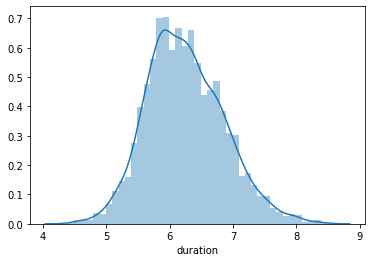

In [17]:
sns.distplot(np.log(df['duration']));

In [18]:
df['log_consult_duration'] = np.log(df['duration'])

In [19]:
df['pain'].value_counts()

no pain          2709
moderate pain     968
severe pain       743
Name: pain, dtype: int64

In [20]:
pain_map = {'no pain': 0, 'moderate pain': 1, 'severe pain': 2}
df['pain_enc'] = df['pain'].map(pain_map)
df['pain_enc'].value_counts()

0    2709
1     968
2     743
Name: pain_enc, dtype: int64

In [21]:
df['priority'].value_counts()

normal    3154
urgent    1266
Name: priority, dtype: int64

In [22]:
priority_map = {'normal': 0, 'urgent': 1}
df['priority_enc'] = df['priority'].map(priority_map)
df['priority_enc'].value_counts()

0    3154
1    1266
Name: priority_enc, dtype: int64

In [23]:
# df['assessment_duration'] = df['assessment_end_time'] - df['assessment_start_time']

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 131 to 4334
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               4420 non-null   int64  
 1   arrival_time             4420 non-null   int64  
 2   assessment_end_time      4420 non-null   int64  
 3   assessment_start_time    4420 non-null   int64  
 4   consultation_end_time    4420 non-null   int64  
 5   consultation_start_time  4420 non-null   int64  
 6   day                      4420 non-null   int64  
 7   duration                 4420 non-null   int64  
 8   pain                     4420 non-null   object 
 9   patient                  4420 non-null   int64  
 10  priority                 4420 non-null   object 
 11  temperature              4420 non-null   float64
 12  log_consult_duration     4420 non-null   float64
 13  pain_enc                 4420 non-null   int64  
 14  priority_enc          

In [25]:
cols_to_drop = ['Unnamed: 0','consultation_end_time', 'duration','pain',
                'patient', 'priority', 'arrival_time', 'assessment_start_time']
df.drop(cols_to_drop, axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 131 to 4334
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   assessment_end_time      4420 non-null   int64  
 1   consultation_start_time  4420 non-null   int64  
 2   day                      4420 non-null   int64  
 3   temperature              4420 non-null   float64
 4   log_consult_duration     4420 non-null   float64
 5   pain_enc                 4420 non-null   int64  
 6   priority_enc             4420 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 276.2 KB


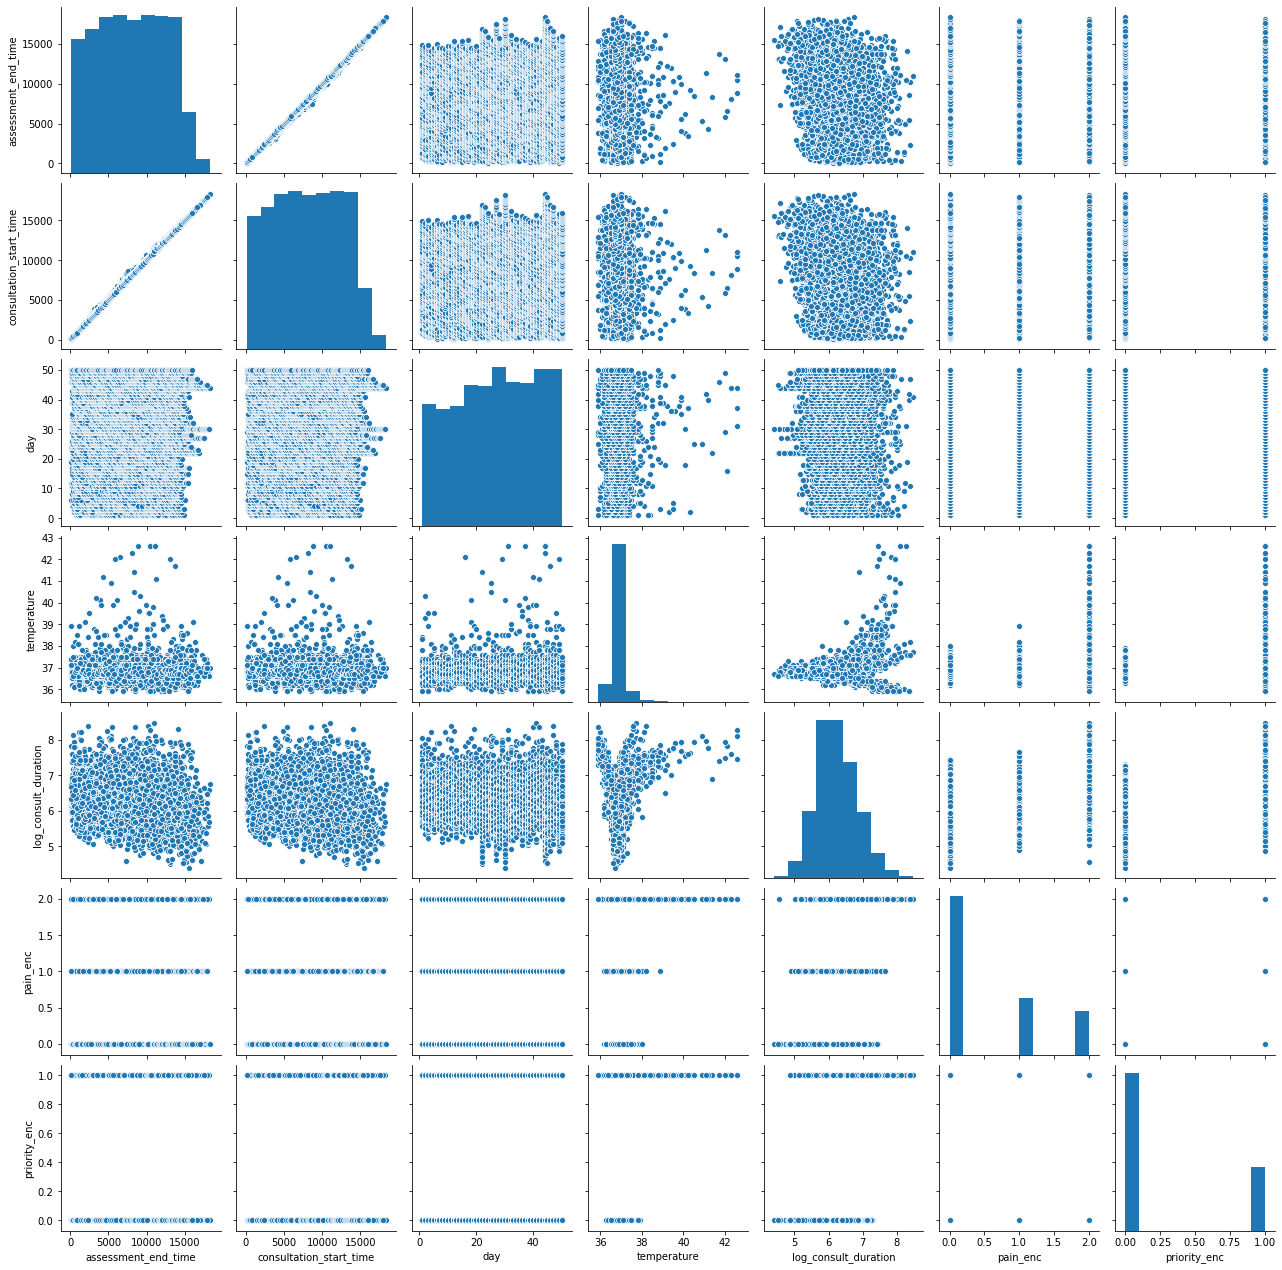

In [27]:
sns.pairplot(df);

In [28]:
X_train = df[df['day'] <= 45].drop(['day', 'log_consult_duration'], axis=1)
X_test = df[df['day'] > 45].drop(['day', 'log_consult_duration'], axis=1)
y_train = df.loc[df['day'] <= 45, 'log_consult_duration']
y_test = df.loc[df['day'] > 45, 'log_consult_duration']

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(normalize=False, random_state=42)

ridge_params ={'alpha': ss.uniform(0, 1)}

rscv = RandomizedSearchCV(ridge,
                          ridge_params,
                          n_iter=1000,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=tscv,
                          verbose=1,
                          random_state=42,
                          return_train_score=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rscv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 4324 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    5.5s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=42, solver='auto', tol=0.001),
                   iid='deprecated', n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdafe95b950>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=1)

In [30]:
lm = rscv.best_estimator_
lm

Ridge(alpha=0.9997176732861306, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [31]:
cv_results = pd.DataFrame(rscv.cv_results_)
train_rmse = -cv_results.loc[rscv.best_index_, 'mean_train_score']
val_rmse = -cv_results.loc[rscv.best_index_, 'mean_test_score']

test_rmse = mean_squared_error(y_test, lm.predict(X_test_scaled))

print(f'train rmse: {train_rmse}')
print(f'val rmse: {val_rmse}')
print(f'test rmse: {test_rmse}')

train rmse: 0.43152299055572324
val rmse: 0.47100647965456705
test rmse: 0.20948409462471
